In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [216]:
nat_gas = pd.read_csv("/Users/talhajamal/Desktop/Code/Python_Projects/JP Morgan - Quant (Forage)/data/Nat_Gas.csv")

In [217]:
nat_gas.head()
nat_gas.tail()

,Dates,Prices
43,5/31/24,11.4
44,6/30/24,11.5
45,7/31/24,11.6
46,8/31/24,11.5
47,9/30/24,11.8


In [218]:
nat_gas.describe()

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


In [219]:
nat_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes


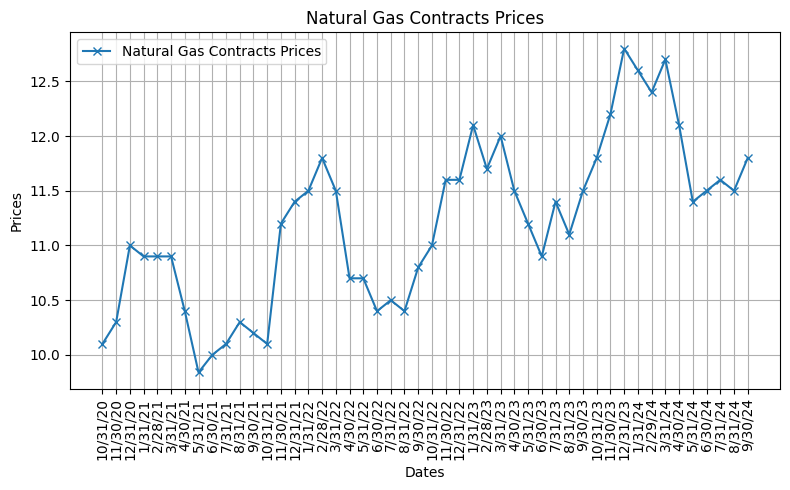

In [220]:
plt.figure(figsize=(8, 5))
plt.plot(nat_gas['Dates'], nat_gas['Prices'], label='Natural Gas Contracts Prices', marker = 'x')
plt.title('Natural Gas Contracts Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(rotation='vertical')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The series seems to be trending upwards and might have a seasonality component to it. 

In [221]:
# Lets plot data for every year individually
nat_gas_separated = nat_gas.copy(deep=True)
nat_gas_separated['Dates'] = pd.to_datetime(nat_gas_separated['Dates'], format='%m/%d/%y')
nat_gas_separated['year'] = nat_gas_separated['Dates'].dt.year
nat_gas_separated['month'] = nat_gas_separated['Dates'].dt.month
nat_gas_separated.drop(['Dates'], axis=1, inplace=True)
nat_gas_separated = nat_gas_separated.pivot_table(index='month',  columns='year', values='Prices')

nat_gas_separated

year,2020,2021,2022,2023,2024
month,,,,,
1,NaN,10.90,11.5,12.1,12.6
2,NaN,10.90,11.8,11.7,12.4
3,NaN,10.90,11.5,12.0,12.7
4,NaN,10.40,10.7,11.5,12.1
5,NaN,9.84,10.7,11.2,11.4
6,NaN,10.00,10.4,10.9,11.5
7,NaN,10.10,10.5,11.4,11.6
8,NaN,10.30,10.4,11.1,11.5
9,NaN,10.20,10.8,11.5,11.8


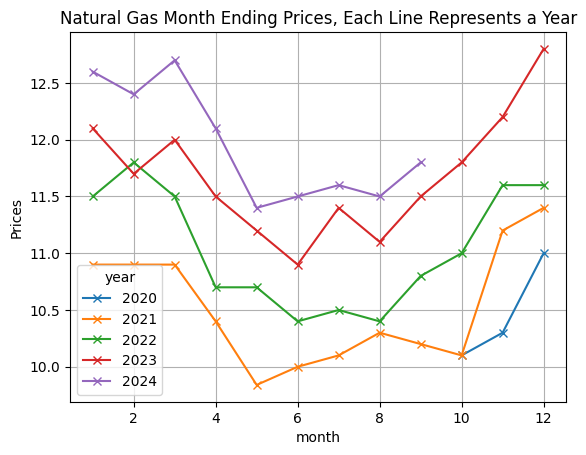

In [222]:
# Plot Data
nat_gas_separated.plot(marker = 'x')
plt.ylabel('Prices')
plt.title("Natural Gas Month Ending Prices, Each Line Represents a Year")
plt.grid(True)
plt.show()

Seasonality seems to be present within the data. During the Winter months the prices of natural gas contracts rise presumable due to higher demand for heating. The prices decrease during the summer presumable due to lower demand. 

In [223]:
# Prepare data 
nat_gas_linear = nat_gas.copy(deep=True)
nat_gas_linear['month'] = pd.DatetimeIndex(nat_gas_linear['Dates']).month

# One Hot Encoding of Monthly Data
nat_gas_linear = pd.get_dummies(nat_gas_linear, columns=['month'])
nat_gas_linear.head()

,Dates,Prices,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,10/31/20,10.1,False,False,False,False,False,False,False,False,False,True,False,False
1,11/30/20,10.3,False,False,False,False,False,False,False,False,False,False,True,False
2,12/31/20,11.0,False,False,False,False,False,False,False,False,False,False,False,True
3,1/31/21,10.9,True,False,False,False,False,False,False,False,False,False,False,False
4,2/28/21,10.9,False,True,False,False,False,False,False,False,False,False,False,False


## Prediction using a Linear Regression Model

In [224]:
nat_gas_linear['Dates'] = pd.to_datetime(nat_gas_linear['Dates'], format='%m/%d/%y')
train_data = nat_gas_linear[nat_gas_linear['Dates'] < '2023-10-31']
test_data = nat_gas_linear[nat_gas_linear['Dates'] >= '2023-10-31']

In [225]:
regression = LinearRegression().fit(train_data.iloc[:, 2:], train_data['Prices'])

In [226]:
nat_gas_predicted = regression.predict(test_data.iloc[:, 2:])
test_data['Predicted'] = nat_gas_predicted
print("Mean squared error: %.3f" % mean_squared_error(test_data['Prices'], nat_gas_predicted))

print("R squared: %.3f" % r2_score(test_data['Prices'], nat_gas_predicted))
test_data.head(2)

Mean squared error: 1.252
R squared: -4.389


,Dates,Prices,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Predicted
36,2023-10-31,11.8,False,False,False,False,False,False,False,False,False,True,False,False,10.406250
37,2023-11-30,12.2,False,False,False,False,False,False,False,False,False,False,True,False,11.023438


Clearly a Linear Model is not appropriate for our data. 

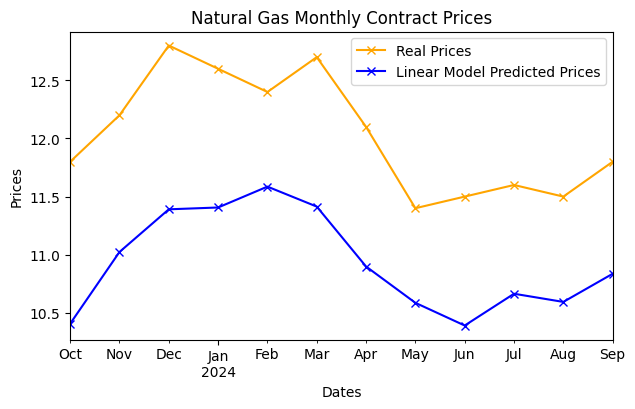

In [227]:
# Plotting predicted values and actual values
test_data.set_index('Dates', inplace=True)
plt.figure(figsize=(7, 4), dpi=100)

test_data['Prices'].plot(label='Real Prices', color='orange', marker = 'x')
test_data['Predicted'].plot(label='Linear Model Predicted Prices', color='blue', marker = 'x')

plt.title('Natural Gas Monthly Contract Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')

plt.legend(loc='upper right')

The Linear Model seems to follow the trend generally - but has a major shift in its predicted prices.

# SARIMA Model

In [228]:
# Test whether time series is stationary
def dicker_fuller(timeseries):
    print ('Dickey-Fuller Test indicates:')
    df_test = adfuller(timeseries, regression='ct', autolag='AIC')
    output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    return(output)

print(dicker_fuller(nat_gas['Prices']))

Dickey-Fuller Test indicates:
Test Statistic                 -2.058395
p-value                         0.569301
#Lags Used                     10.000000
Number of Observations Used    37.000000
dtype: float64


The results indicate that this time seris is NOT stationary. 

In [229]:
ts_diff= nat_gas['Prices'].diff(periods=1).dropna()
print(dicker_fuller(ts_diff))

Dickey-Fuller Test indicates:
Test Statistic                -6.746167e+00
p-value                        5.257647e-08
#Lags Used                     9.000000e+00
Number of Observations Used    3.700000e+01
dtype: float64


In [230]:
ts_diff.head()

1    0.2
2    0.7
3   -0.1
4    0.0
5    0.0
Name: Prices, dtype: float64

Text(0, 0.5, 'Prices')

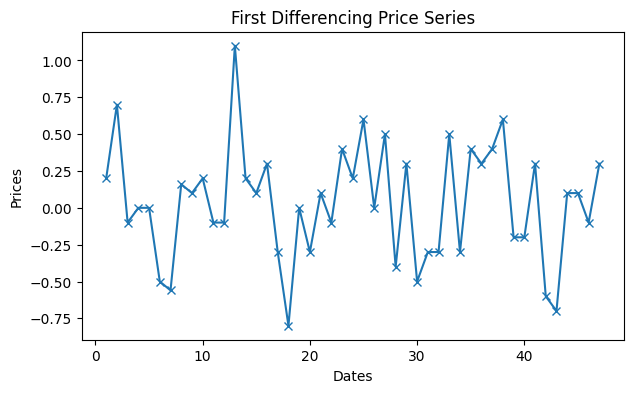

In [231]:
plt.figure(figsize=(7, 4), dpi=100)
ts_diff.plot(label = 'First Difference', marker='x')
plt.title('First Differencing Price Series')
plt.xlabel('Dates')
plt.ylabel('Prices')

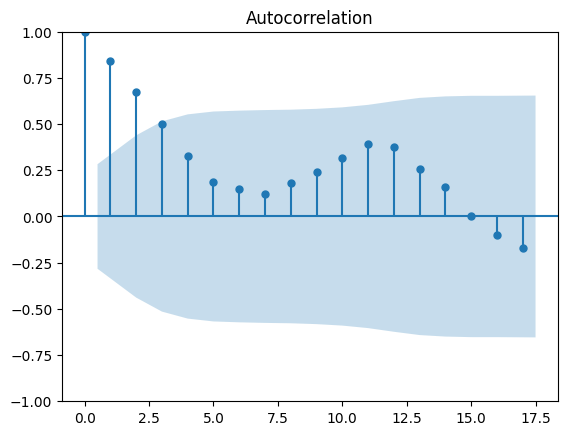

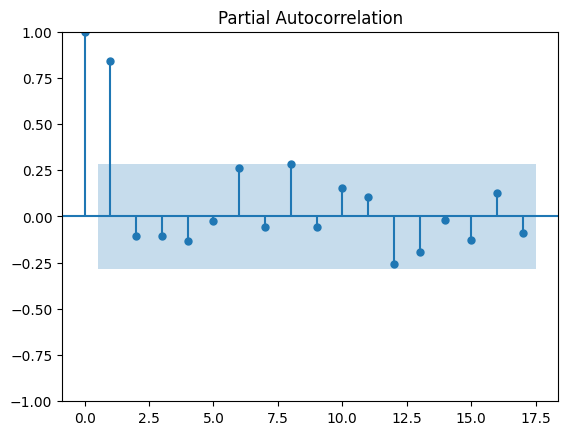

In [232]:
plot_acf(nat_gas['Prices'])
plt.show()
plot_pacf(nat_gas['Prices'])
plt.show()

In [233]:
train_data_SARIMA = train_data.copy(deep=True)
test_data_SARIMA = test_data.copy(deep=True)

In [234]:
AR = [1,2,3,4,5]
MA = [1,2,3,4,5]
model = sm.tsa.statespace.SARIMAX(train_data_SARIMA['Prices'],
                         order=(1, 1, 1),
                         seasonal_order=(1, 1, 1, 12))
result = model.fit()
print(result.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83970D-01    |proj g|=  2.08451D-01

At iterate    5    f=  5.03660D-02    |proj g|=  2.11493D-01

At iterate   10    f=  4.24319D-02    |proj g|=  4.83595D-03

At iterate   15    f=  3.77618D-02    |proj g|=  1.69252D-01

At iterate   20    f=  3.27433D-02    |proj g|=  1.22230D-02

At iterate   25    f=  3.03138D-02    |proj g|=  5.83034D-02

At iterate   30    f=  2.96750D-02    |proj g|=  6.09030D-02

At iterate   35    f=  2.94181D-02    |proj g|=  1.56020D-02

At iterate   40    f=  2.93038D-02    |proj g|=  3.68648D-02

At iterate   45    f=  2.92552D-02    |proj g|=  3.01942D-02

At iterate   50    f=  2.92393D-02    |proj g|=  2.04829D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

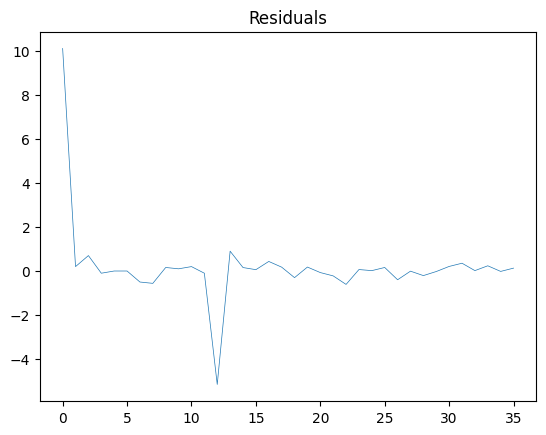

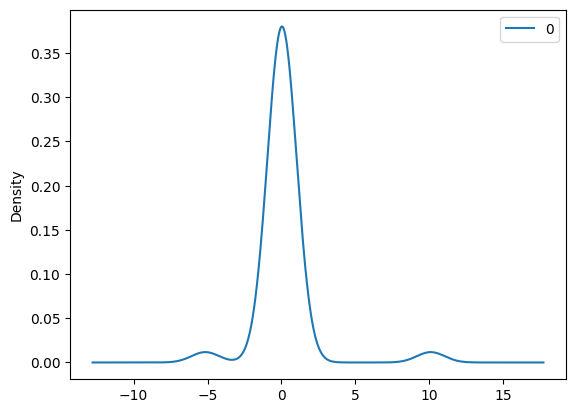

In [235]:
#Checking for obvious patterns in residuals. Any pattern is a bad sign.
residuals = pd.DataFrame(result.resid)
residuals.plot(linewidth=0.5, legend=None)
plt.title('Residuals')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

In [236]:
test_data_SARIMA.shape

(12, 14)

In [237]:
#Training the model again after each prediction, making one-step-ahead prediction each time
# print(f'Size of data is {nat_gas.size} and train set size is {train_data_SARIMA.size}')
one_step_predictions = pd.Series([])
for i in range(test_data_SARIMA.shape[0]):
  data = pd.concat([train_data_SARIMA['Prices'], one_step_predictions], ignore_index=True)
  model = sm.tsa.statespace.SARIMAX(data,
                         order=(1, 1, 1),
                         seasonal_order=(1, 1, 1, 12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
  result = model.fit()
  one_step_predictions = pd.concat([one_step_predictions, pd.Series(result.predict(i).values[0])], ignore_index = True)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.67725D-02    |proj g|=  9.38480D-01

At iterate    5    f= -7.41952D-02    |proj g|=  1.44920D-01

At iterate   10    f= -9.46554D-02    |proj g|=  1.34756D-01

At iterate   15    f= -1.04555D-01    |proj g|=  1.78664D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   5.897D-05  -1.046D-01
  F = -0.10455464997144404     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.33528D-01    |proj g|=  3.81951D-02

At iterate   10    f=  8.14400D-01    |proj g|=  2.08698D-02

At iterate   15    f=  7.99303D-01    |proj g|=  6.50972D-03

At iterate   20    f=  7.95293D-01    |proj g|=  6.71620D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     41      1     0     0   8.955D-04   7.953D-01
  F =  0.79529232171246078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.89541D-01    |proj g|=  1.35440D-02

At iterate   10    f=  8.69763D-01    |proj g|=  1.56878D-02

At iterate   15    f=  8.68765D-01    |proj g|=  2.23552D-04

At iterate   20    f=  8.67945D-01    |proj g|=  7.39772D-03

At iterate   25    f=  8.67758D-01    |proj g|=  7.36461D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     41      1     0     0   4.985D-05   8.678D-01
  F =  0.86775831530938907     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86672D-01    |proj g|=  1.63769D-01

At iterate    5    f=  9.43156D-01    |proj g|=  1.16295D-02

At iterate   10    f=  9.27427D-01    |proj g|=  2.14672D-02

At iterate   15    f=  9.24570D-01    |proj g|=  7.91511D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     24      1     0     0   1.452D-05   9.246D-01
  F =  0.92456937336970335     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     25      1     0     0   5.962D-05   9.692D-01
  F =  0.96919549317786291     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05390D+00    |proj g|=  1.72166D-01

At iterate    5    f=  1.00904D+00    |proj g|=  1.22259D-02

At iterate   10    f=  9.91805D-01    |proj g|=  2.46924D-02

At iterate   15    f=  9.90585D-01    |proj g|=  1.22344D-04

       


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


In [238]:
one_step_predictions.index = test_data_SARIMA.index

In [239]:
test_data_SARIMA['Prediction'] = one_step_predictions
test_data_SARIMA

,Prices,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Predicted,Prediction
Dates,,,,,,,,,,,,,,,
2023-10-31,11.8,False,False,False,False,False,False,False,False,False,True,False,False,10.406250,0.000000
2023-11-30,12.2,False,False,False,False,False,False,False,False,False,False,True,False,11.023438,5.296166
2023-12-31,12.8,False,False,False,False,False,False,False,False,False,False,False,True,11.390625,11.774883
2024-01-31,12.6,True,False,False,False,False,False,False,False,False,False,False,False,11.406250,10.946019
2024-02-29,12.4,False,True,False,False,False,False,False,False,False,False,False,False,11.585938,10.923002
2024-03-31,12.7,False,False,True,False,False,False,False,False,False,False,False,False,11.414062,10.900079
2024-04-30,12.1,False,False,False,True,False,False,False,False,False,False,False,False,10.898438,10.900679
2024-05-31,11.4,False,False,False,False,True,False,False,False,False,False,False,False,10.585938,10.295813
2024-06-30,11.5,False,False,False,False,False,True,False,False,False,False,False,False,10.390625,9.705025


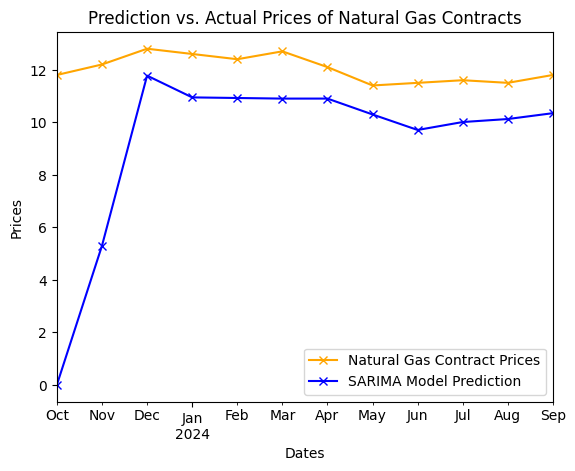

In [240]:
test_data_SARIMA['Prices'].plot(label='Natural Gas Contract Prices', color='orange', marker = 'x')
test_data_SARIMA['Prediction'].plot(label='SARIMA Model Prediction', color='blue', marker = 'x')
plt.title("Prediction vs. Actual Prices of Natural Gas Contracts")
plt.xlabel('Dates')
plt.ylabel('Prices')

plt.legend(loc='lower right')